Fitting 5 folds for each of 8 candidates, totalling 40 fits
最佳参数: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
交叉验证平均准确率: 68.57% (±14.00%)
可视化完成！生成文件：
- base_features_radar.png
- base_accuracy_distribution.png


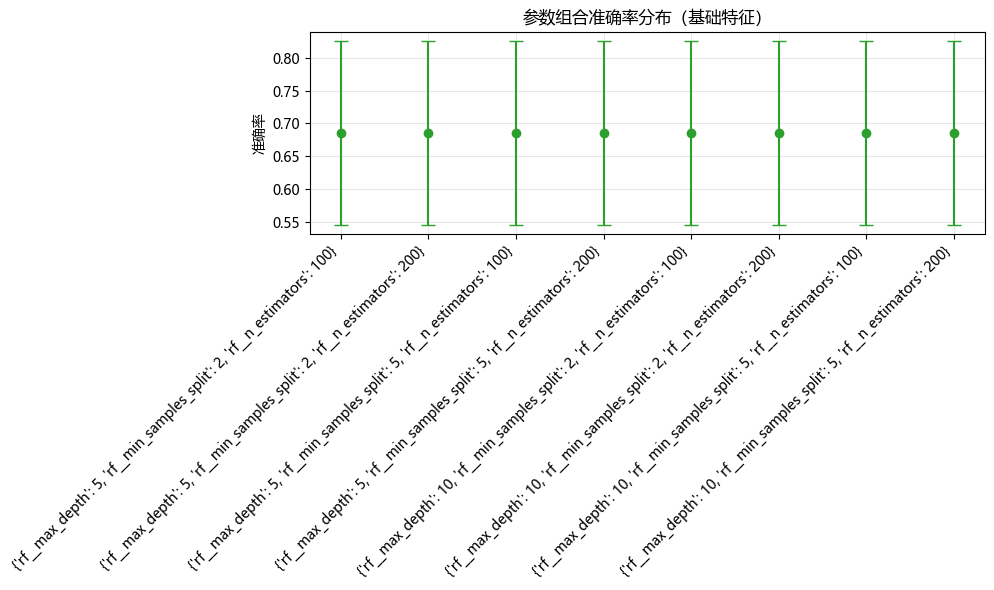

In [1]:
# ========== 计算部分 ==========
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt

# 材料属性定义
material_properties = {
    '卡纸': {'smoothness': 2, 'weight_gsm': 200, 'stiffness': 4},
    'A4纸': {'smoothness': 3, 'weight_gsm': 80, 'stiffness': 2},
    '覆膜纸': {'smoothness': 4, 'weight_gsm': 150, 'stiffness': 3},
    '锡箔纸': {'smoothness': 5, 'weight_gsm': 50, 'stiffness': 1}
}

def load_data():
    """安全加载数据（无交互项版本）"""
    try:
        df = pd.read_excel('试验数据登记表.xlsx',
                          sheet_name='Sheet1',
                          header=2,
                          usecols="A:F",  # 排除无关列
                          engine='openpyxl')
        df.columns = ['纸张类型', '飞机类型', '实验编号', 
                     '飞行时长/s', '飞行距离/m', '飞行平稳性']
        df['纸张类型'] = df['纸张类型'].ffill().str.strip()
        return df
    except Exception as e:
        print(f"数据加载失败: {str(e)}")
        return None

def main_analysis():
    # 加载数据
    df = load_data()
    if df is None:
        return
    
    # 合并材料特征（仅基础特征）
    material_data = []
    for pt in df['纸张类型']:
        props = material_properties.get(pt)
        if not props:
            raise ValueError(f"未定义的材料类型: {pt}")
        material_data.append({
            'smoothness': props['smoothness'],
            'weight_gsm': props['weight_gsm'],
            'stiffness': props['stiffness']
        })
    df = pd.concat([df, pd.DataFrame(material_data)], axis=1)
    
    # 定义特征和目标（无交互项）
    features = ['smoothness', 'weight_gsm', 'stiffness']
    target = '飞行平稳性'
    df_clean = df[features + [target]].dropna()
    
    # 构建模型管道
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(k_neighbors=3, random_state=42)),
        ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    
    # 参数网格
    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [5, 10],
        'rf__min_samples_split': [2, 5]
    }
    
    # 交叉验证设置
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 执行网格搜索
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(df_clean[features], df_clean[target])
    
    # 保存结果
    joblib.dump(grid_search.best_estimator_, 'best_model_base.pkl')
    feature_importance = pd.DataFrame({
        '特征': features,
        '重要性': grid_search.best_estimator_.named_steps['rf'].feature_importances_
    })
    feature_importance.to_csv('feature_importance_base.csv', index=False)
    
    # 输出交叉验证结果
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results[['params', 'mean_test_score', 'std_test_score']].to_csv('cv_results_base.csv', index=False)
    
    print("="*40)
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"交叉验证平均准确率: {grid_search.best_score_:.2%} (±{cv_results.std_test_score.mean():.2%})")

# ========== 可视化部分 ==========
def visualize_base_features():
    """基础特征可视化"""
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    try:
        # 读取特征重要性
        importance = pd.read_csv('feature_importance_base.csv')
        
        # ===== 雷达图 =====
        labels = ['光滑度', '克重(g/m²)', '硬度']
        values = importance['重要性'].tolist() + [importance['重要性'].iloc[0]]
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
        angles += angles[:1]
        
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(polar=True)
        ax.plot(angles, values, linewidth=2, color='#1f77b4')
        ax.fill(angles, values, alpha=0.25)
        
        ax.set_theta_offset(np.pi/2)
        ax.set_theta_direction(-1)
        plt.xticks(angles[:-1], labels)
        plt.yticks(np.linspace(0, max(values), 5), [f"{x:.2f}" for x in np.linspace(0, max(values), 5)])
        plt.title('基础材料特性影响雷达图', pad=20, fontsize=14)
        plt.savefig('base_features_radar.png', dpi=300)
        plt.close()
        
        # ===== 准确率分布图 =====
        cv_results = pd.read_csv('cv_results_base.csv')
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            range(len(cv_results)),
            cv_results['mean_test_score'],
            yerr=cv_results['std_test_score'],
            fmt='o',
            capsize=5,
            color='#2ca02c'
        )
        plt.xticks(range(len(cv_results)), 
                  [str(p) for p in cv_results['params']], 
                  rotation=45,
                  ha='right')
        plt.ylabel('准确率')
        plt.title('参数组合准确率分布（基础特征）')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('base_accuracy_distribution.png', dpi=300)
        
        print("可视化完成！生成文件：")
        print("- base_features_radar.png")
        print("- base_accuracy_distribution.png")
    
    except Exception as e:
        print(f"可视化失败: {str(e)}")

if __name__ == "__main__":
    main_analysis()
    visualize_base_features()